<a href="https://colab.research.google.com/github/archangel2006/AgroNomics/blob/main/AgroNomics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgroNomics : A Crop Price Prediction Model

Ordinal Encoding For Categorical Data

Random Forest Regressor For Model

Evlaution Metrics:
- Mean Absolute Error
- Mean Square Error
- R²Score

In [2]:
#!pip install -q scikit-learn==1.4.2 pandas numpy joblib flask flask-cors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
import csv

with open("agridata.csv", "r", encoding="utf-8", errors="ignore") as infile, open("cleaned_agridata.csv", "w", newline="", encoding="utf-8") as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)

    for row in reader:
        try:
            writer.writerow(row)
        except:
            continue  # skip any row that causes a write error


In [3]:
df = pd.read_csv('/content/cleaned_agridata.csv')
df.shape

(183715, 8)

In [4]:
df.sample(2)

,commodity_name,state,district,market,min_price,max_price,modal_price,date
135237,Mango+(Raw-Ripe),Uttar Pradesh,Faizabad,Faizabad,19.25,20.0,19.50,2019-06-29
66388,Ginger(Green),Madhya Pradesh,Ujjain,Ujjain(F&V),30.00,78.0,39.21,2019-06-13


In [5]:
# Step 1: Clean commodity names by replacing "+" with spaces and fixing weird characters
df['commodity'] = (
    df['commodity_name']
    .str.replace('+', ' ', regex=False)            # Replace all "+" with spaces
    .str.replace(r'\+\-+\+', ' ', regex=True)      # Fix patterns like "+-+" (escaped properly)
    .str.strip()                                   # Remove extra spaces
)

# Step 2: Fix known typos to standardize commodity names
typo_fixes = {
    'Soji': 'Sooji',
    'Cucumbar(Kheera)': 'Cucumber',
    'Chilly Capsicum': 'Chilli Capsicum',
    'Corriander seed': 'Coriander seed',
    'Onion Green': 'Green Onion'
}
df['commodity'] = df['commodity'].replace(typo_fixes)


In [6]:
commodity_to_category = {}

# Grains
for item in ['Wheat', 'Rice', 'Maize', 'Jowar(Sorghum)', 'Millets', 'Ragi (Finger Millet)', 'Rajgir',
             'Barley (Jau)', 'Broken Rice', 'Maida Atta', 'Wheat Atta', 'Kodo Millet(Varagu)', 'Beaten Rice',
             'Sooji', 'Sajje','Hybrid Cumbu', 'T.V. Cumbu', 'Lak(Teora)']:
    commodity_to_category[item] = 'Grains'

# Pulses
for item in ['Arhar Dal(Tur Dal)', 'Masur Dal', 'Moath Dal', 'Chennangi Dal', 'Green Avare (W)', 'Avare Dal',
             'Peas(Dry)', 'Peas cod', 'Peas Wet', 'Alasande Gram', 'Field Pea', 'Indian Beans (Seam)',
             'Kulthi(Horse Gram)', 'Same/Savi', 'Gram Raw(Chholia)', 'White Peas', 'Arhar (Tur/Red Gram)(Whole)',
             'Mataki','Duster Beans', 'Guar']:
    commodity_to_category[item] = 'Pulses'

# Oilseeds
for item in ['Soyabean', 'Castor Seed', 'Sunflower', 'Groundnut', 'Ground Nut Seed', 'Linseed',
             'Groundnut (Split)', 'Groundnut pods (raw)', 'Safflower', 'Taramira', 'Niger Seed (Ramtil)',
             'Gurellu']:
    commodity_to_category[item] = 'Oilseeds'

# Vegetables
for item in ['Onion', 'Potato', 'Tomato', 'Cabbage', 'Brinjal', 'Beans', 'Beetroot', 'Bitter gourd',
             'Bottle gourd', 'Capsicum', 'Cauliflower', 'Cluster beans', 'Colacasia', 'Cucumber',
             'Drumstick', 'Green Peas', 'Pumpkin', 'Raddish', 'Ridgeguard(Tori)', 'Ridge gourd(Tori)',
             'Round gourd', 'Snakeguard', 'Snake gourd', 'Sponge gourd', 'Spinach', 'Knool Khol',
             'Leafy Vegetable', 'Turnip', 'Ashgourd', 'Carrot', 'Cowpea(Veg)', 'Green Chilli',
             'Elephant Yam (Suran)', 'Suvarna Gadde', 'Tinda', 'Chow Chow', 'Season Leaves', 'Amaranthus',
             'Mashrooms', 'Mint(Pudina)', 'Methi(Leaves)', 'Thondekai', 'Seemebadnekai', 'Bunch Beans','Sweet Potato',
             'Sweet Pumpkin', 'Yam', 'Yam (Ratalu)', 'Tapioca','Green Onion', 'Surat Beans (Papadi)', 'White Pumpkin', 'Kartali (Kantola)']:
    commodity_to_category[item] = 'Vegetables'

# Fruits
for item in ['Banana', 'Mango', 'Papaya', 'Guava', 'Pomegranate', 'Apple', 'Chikoos(Sapota)', 'Grapes',
             'Litchi', 'Plum', 'Peach', 'Jamun(Narale Hannu)', 'Water Melon', 'Mousambi(Sweet Lime)',
             'Karbuja(Musk Melon)', 'Pear(Marasebu)', 'Banana - Green', 'Papaya (Raw)', 'Mango (Raw-Ripe)',
             'Pineapple', 'Orange', 'Lemon', 'Lime', 'Long Melon(Kakri)', 'Jack Fruit', 'Seetapal',
             'Persimon(Japani Fal)', 'Seetafal', 'Amla(Nelli Kai)', 'Balekai', 'Galgal(Lemon)',
             'Almond(Badam)', 'Walnut', 'Cherry', 'Kinnow']:
    commodity_to_category[item] = 'Fruits'

# Spices & Oils
for item in ['Turmeric', 'Turmeric (raw)', 'Ginger(Dry)', 'Ginger(Green)', 'Cummin Seed(Jeera)', 'Garlic',
             'Mustard', 'Mustard Oil', 'Coconut Oil', 'Gingelly Oil', 'Black pepper', 'Cardamoms', 'Cloves',
             'Nutmeg', 'Pepper garbled', 'Pepper ungarbled', 'Tamarind Seed', 'Tamarind Fruit',
             'Dry Chillies', 'Soanf', 'Suva (Dill Seed)', 'Coriander(Leaves)', 'Coriander seed',
             'Ajwan', 'Chili Red', 'Chilli Capsicum', 'Mint(Pudina)', 'Methi Seeds', 'Isabgul (Psyllium)',
             'Betal Leaves','Mace','Toria']:
    commodity_to_category[item] = 'Spices/Oils'

# Flowers (Horticulture)
for item in ['Marigold(loose)', 'Marigold(Calcutta)', 'Chrysanthemum(Loose)', 'Jasmine', 'Tube Rose(Loose)',
             'Rose(Local)','Anthorium']:
    commodity_to_category[item] = 'Flowers'

# Cash Crops
for item in ['Coffee', 'Cotton', 'Cotton Seed', 'Rubber', 'Cashewnuts', 'Copra', 'Jute', 'Tobacco',
             'Sugarcane', 'Lint', 'Paddy(Dhan)(Basmati)', 'Paddy(Dhan)(Common)','Tender Coconut',
             'Arecanut(Betelnut/Supari)', 'Honge seed', 'Bamboo']:
    commodity_to_category[item] = 'Cash Crop'


# Processed / Value-Added Products
for item in ['Gur(Jaggery)', 'Sugar', 'Dry Grapes', 'Bran', 'Gramflour']:
    commodity_to_category[item] = 'Processed'

# Fodder / Fiber / Utility Crops
for item in ['Dry Fodder', 'Green Fodder', 'Dhaincha', 'Sunhemp', 'Lukad', 'Siddota']:
    commodity_to_category[item] = 'Fodder/Fiber'

# Non-Crop (Livestock or Derived)
for item in ['Egg', 'Fish', 'Hen', 'Cow', 'Goat', 'Sheep', 'Pigs', 'Calf', 'Ox', 'Duck', 'Cock',
             'She Buffalo', 'He Buffalo', 'Bull', 'Ram', 'She Goat', 'Khoya', 'Butter', 'Ghee', 'Firewood',
             'Wood', 'Dalda']:
    commodity_to_category[item] = 'Non-Crop'

# Other
for item in ['Amphophalus', 'Antawala', 'Chapparad Avare', 'Cocoa', 'Coconut', 'Coconut Seed', 'Mahua',
             'Myrobolan(Harad)', 'Neem Seed', 'Lotus Sticks', 'Alsandikai', 'Mahedi', 'Thogrikai', 'Ambada Seed',
             'Indian Colza(Sarson)', 'Sabu Dan', 'Sabu Dana', 'Coca', 'Hippe Seed', 'Rose(Loose)']:
    commodity_to_category[item] = 'Other'


In [7]:
# Dropping 'commodity_name' Columns

df.drop(columns=['commodity_name'], inplace=True)

In [8]:
# Mapping Category To Crops

df['category'] = df['commodity'].map(commodity_to_category)

In [9]:
# Removing rows that aren't crops

df = df[df['category']!='Non-Crop']

In [10]:
# Filter and display unique commodities with missing categories

missing_category_crops = df[df['category'].isna()]['commodity'].unique()
print("Commodities with missing categories:")
print(missing_category_crops)


Commodities with missing categories:
['Other Pulses']


In [11]:
# Removing Rows With Unwanted Or Missing Commodities

df = df[~df['commodity'].isin(['Other Pulses'])]
df = df[df['commodity'].notna()]


In [12]:
# Checking If Any Missing Categories?

missing_category_crops = df[df['category'].isna()]['commodity'].unique()
print("Commodities with missing categories:")
print(missing_category_crops)


Commodities with missing categories:
[]


In [13]:
# Data Type OF 'date'

df['date'].dtype

dtype('O')

In [14]:
# Converting date to datetime
df['date'] = pd.to_datetime(df['date'], format='mixed',dayfirst=True)

# Extracting month
df['month'] = df['date'].dt.month


In [15]:
# Adding Season

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

df['season'] = df['month'].apply(get_season)


In [16]:
# Drop 'date' Columns, Not Required

df = df.drop('date',axis=1)

In [17]:
# Outlier Detection

Q1 = df['modal_price'].quantile(0.25)
Q3 = df['modal_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['modal_price'] < lower_bound) | (df['modal_price'] > upper_bound)]
print(len(outliers), "out of", len(df), "rows")

11005 out of 183071 rows


In [18]:
#Removing Outliers

df = df[(df['modal_price'] >= lower_bound) & (df['modal_price'] <= upper_bound)]

In [19]:
# First 5 Rows

df.head()

,state,district,market,min_price,max_price,modal_price,commodity,category,month,season
6,Rajasthan,Chittorgarh,Nimbahera,9.77,9.95,9.80,Ajwan,Spices/Oils,5.0,Summer
8,Karnataka,Bagalkot,Bagalakot,46.01,46.50,46.46,Alasande Gram,Pulses,5.0,Summer
9,Karnataka,Bangalore,Bangalore,48.00,53.00,50.50,Alasande Gram,Pulses,5.0,Summer
10,Karnataka,Gadag,Laxmeshwar,22.15,46.41,36.54,Alasande Gram,Pulses,5.0,Summer
11,Madhya Pradesh,Panna,Ajaygarh,41.00,46.20,42.00,Alasande Gram,Pulses,5.0,Summer


In [20]:
# Renaming 'commodity' to 'crop' if 'commodity' exists and 'crop' doesn't, to standardize column naming

if 'commodity' in df.columns and 'crop' not in df.columns:
    df = df.rename(columns={'commodity': 'crop'})

In [21]:
# Not Required

df= df.drop('min_price', axis=1)

In [22]:
# Not Required

df = df.drop('max_price', axis=1)

In [23]:
# Sample Rows

df.sample(2)

,state,district,market,modal_price,crop,category,month,season
117942,Haryana,Ambala,Naraingarh,42.0,Mango,Fruits,6.0,Monsoon
168201,Uttar Pradesh,Mainpuri,Mainpuri,22.2,Banana,Fruits,9.0,Post-Monsoon


In [24]:
# Checking If All Columns Are Present

required_cols = [
    'category', 'crop',
    'state', 'district', 'modal_price',
    'month', 'season'
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

In [25]:
# Defining Target & Features

x = df[['category', 'crop', 'state', 'district', 'month', 'season']]
y = df['modal_price']

In [26]:
# Categorical Columns For Encoding

cat_cols = ['category', 'crop', 'state', 'district', 'season']

In [30]:
# Ordinal encoding

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
x.loc[:, cat_cols] = encoder.fit_transform(x[cat_cols])

In [31]:
x.sample(3)

,category,crop,state,district,month,season
146595,10.0,26.0,26.0,410.0,8.0,0.0
174776,4.0,92.0,5.0,288.0,7.0,0.0
127263,4.0,92.0,5.0,345.0,6.0,0.0


In [32]:
# Splitting data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [33]:
# Training Random Forest

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [34]:
# Prediction

y_pred = rf_model.predict(x_test)

In [35]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R2   : {r2:.2f}")

Model Performance:
MAE  : 3.25
RMSE : 5.64
R2   : 0.88


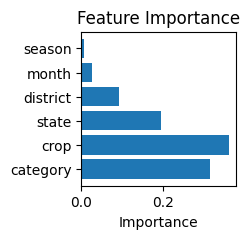

In [37]:
# Plotting Feature Importance

plt.figure(figsize=(2,2))
importances = rf_model.feature_importances_
feat_names = x.columns

plt.barh(feat_names, importances)
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()


In [43]:
# Testing Sample Input

sample_data = pd.DataFrame([{
    "category": "Fruits",
    "crop": "Banana",
    "state": "Uttar Pradesh",
    "district": "Sitapur",
    "month": 6.0,
    "season": "Monsoon"
}])

sample_data[cat_cols] = encoder.transform(sample_data[cat_cols])

# Predict
predicted_price = rf_model.predict(sample_data)[0]
print(f"Predicted Price: {predicted_price:.2f}")


Predicted Price: 70.79


In [41]:
import joblib

# Save model and encoder
joblib.dump(rf_model, "model.pkl")
joblib.dump(encoder, "encoder.pkl")

print("Model and encoder saved!")


Model and encoder saved!


In [42]:
# Dowload Model & Encoder

from google.colab import files
files.download("model.pkl")
files.download("encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>